In [27]:
import cv2
import os
import numpy as np

In [28]:
def save_stereo_img_left_and_right(stereo_img, i):
    # Separate into two images
    h, w, _ = stereo_img.shape
    mid = w // 2

    left_img = stereo_img[:, :mid]
    right_img = stereo_img[:, mid:]
    # Additional image information
    object_name = "null"
    # Make folder names
    left_images_save_path = f"{object_name}left_images"
    right_images_save_path = f"{object_name}right_images"


    # Create the save path if it doesn't exist
    
    os.makedirs(left_images_save_path, exist_ok=True)
    os.makedirs(right_images_save_path, exist_ok=True)

    # Save
    left_img_file_name = f"{left_images_save_path}/left_img_{i + 1}.png"
    right_img_file_name = f"{right_images_save_path}/right_img_{i + 1}.png"

    # Save to file 
    cv2.imwrite(left_img_file_name, left_img)
    print(f"Image {i + 1} captured and separated as {left_img_file_name}")
    cv2.imwrite(right_img_file_name, right_img)
    print(f"Image {i + 1} captured and saved as {right_img_file_name}")


def list_available_cameras():
    # Try to open each camera index and print information
    for i in range(10):  # Try indices from 0 to 9
        cap = cv2.VideoCapture(i)
        if not cap.isOpened():
            break
        else:
            print(f"Camera Index {i}: {cap.get(cv2.CAP_PROP_FRAME_WIDTH)} x {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}")
            cap.release()

def capture_images(camera_index=0, num_images=10, save_path='captured_images'):
    print("Camera index: ", camera_index)
    # Create a VideoCapture object
    cap = cv2.VideoCapture(camera_index)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    # Create the save path if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    cv2.waitKey(1500)
    print(f"Capturing {num_images} images from camera {camera_index}...")
    
    for i in range(num_images):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Display the frame
        cv2.imshow('Frame', frame)

        # Save the frame as an image
        image_filename = f"{save_path}/image_{i + 1}.png"
        cv2.imwrite(image_filename, frame)

        save_stereo_img_left_and_right(frame, i)

        print(f"Image {i + 1} captured and saved as {image_filename}")

        # Wait for a short time between captures (milliseconds)
        cv2.waitKey(500)

    # Release the VideoCapture object
    cap.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()

if __name__ == "__main__":
    # Specify the camera index (0 by default, which is usually the built-in webcam)
    # You may need to change the index if you have multiple cameras
    camera_index = 0

    # Number of images to capture
    num_images = 20

    # Specify the folder to save the captured images
    save_path = 'captured_images'

    list_available_cameras()

    # Call the capture_images function
    capture = False
    if capture:
        capture_images(camera_index, num_images, save_path)

Camera Index 0: 640.0 x 480.0


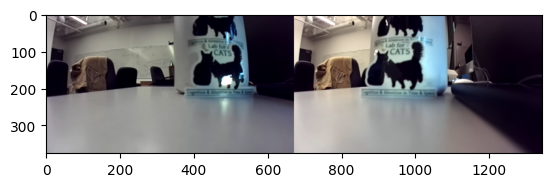

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('captured_images/image_10.png')
plt.imshow(img)
plt.show()

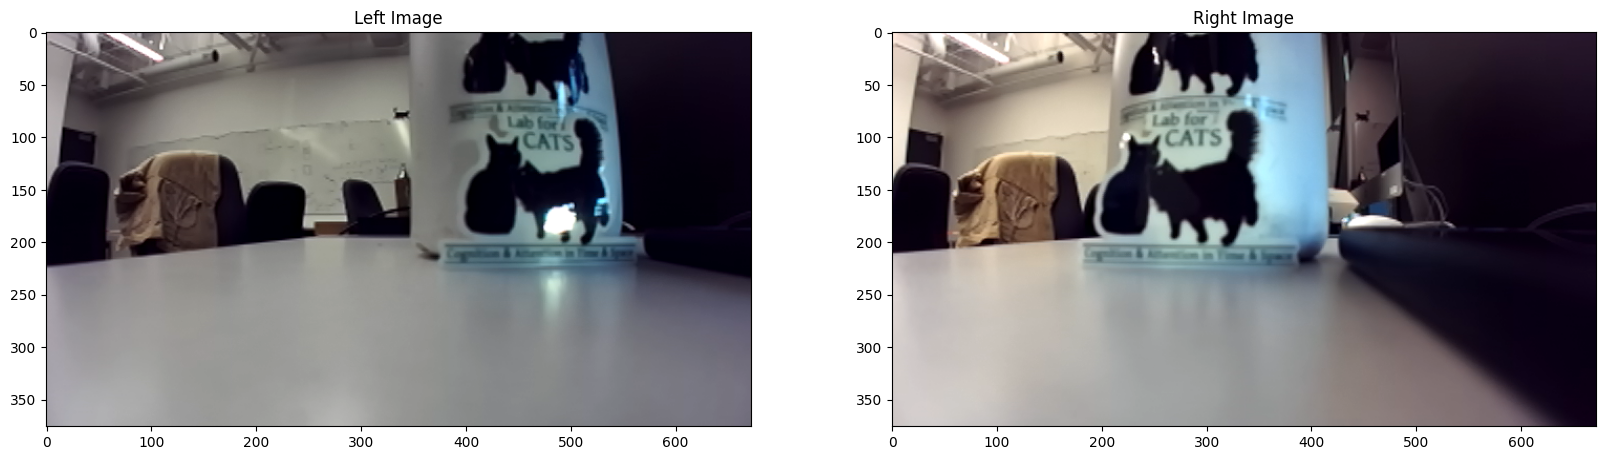

In [30]:
h, w, _ = img.shape
mid = w // 2

left_img = img[:, :mid]
right_img = img[:, mid:]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(left_img)
axs[0].set_title("Left Image")
# axs[0].axis('off')

axs[1].imshow(right_img)
axs[1].set_title("Right Image")
# axs[1].axis('off')

plt.show()

1. Match key points via orb or sift or whichever one is better. Figure out of super pixels will help
    
2. Match keypoints in a more manual way that is explainable to students (either patch matching or creating your own filter). Figure out of super pixels will help

3. Get a display of matches for both

4. Figure out how to do depth matching algorithm after finding correspondences 

In [31]:
def imload(impath):
    img = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    return img, gray

#### Below shows a sparse correspondence ####

Found 148 matches.


(-0.5, 1343.5, 375.5, -0.5)

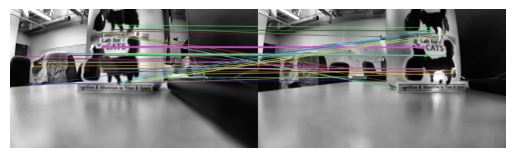

In [32]:
# Get left and right image
img_left, img_left_gray = imload("10cm_awayleft_images/left_img_10.png")
img_right, img_right_gray = imload("10cm_awayright_images/right_img_10.png")

# We per form histogram equalization on the images to make them sharper
# clahe stands for contrast limited adaptive histogram equalization
# sadly, histogram equalization only works with gray scale images
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_left_histEq = clahe.apply(img_left_gray)
img_right_histEq = clahe.apply(img_right_gray)

# We need to find the correspondences
descriptor = cv2.ORB_create()

# keypoints are the actual points in the image
# kps ar ethe actual points in the image
# featuresL is an embedding that describes those points
kpsL, featsL = descriptor.detectAndCompute(img_left_gray, None)
kpsR, featsR = descriptor.detectAndCompute(img_right_gray, None)

# NOw create the matcher and find matches
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = matcher.match(featsR,featsL)

print('Found ' + str(len(matches)) + ' matches.')

# Next we draw the matches
# Sort matches using lambda notation - lifted straight from Silva's code, because I can never remember this syntax
sorted_matches = sorted(matches, key = lambda x:x.distance)

# The number of matches to keep
# Note that when finding the homography, we probably want a good number (~100 or so)
# For visualization, we can always drop this way down to really get a clear look at what is being matched
num_keep = 50 

matched_img = cv2.drawMatches(img_right_histEq, kpsR, img_left_histEq, kpsL, sorted_matches[:num_keep], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_img)
plt.axis('off')

# Now we just need some constants b, and f_x where b is the distance between cameras and f_x
# is a camera intrinsic

(-0.5, 1343.5, 375.5, -0.5)

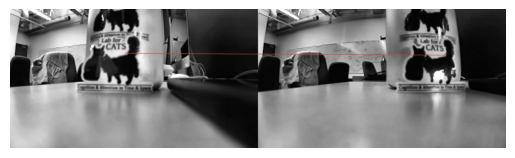

In [34]:
# Now we get a correspondence from the sticker because that is 10cm away
# The start to end range gives us a match that is on the object 10cm away
start = 15
end = 16
matched_img = cv2.drawMatches(img_right_histEq, kpsR, img_left_histEq, kpsL, sorted_matches[start:end], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_img)
plt.axis('off')

#### Now we will show a dense correspondence ####


In [47]:
# We will use sum of squared distance's (SSD) as our cost calculation 
def cost_function(array1, array2):
    # Made it like this so you can easily switch out cost functions
    return SSD_cost(array1, array2)

def SSD_cost(array1, array2):
    """
    Description:

    Paramters:
        array1, numpy array
        array2, numpy array
    Returns:

    """
    return np.sum((array1-array2)**2, axis=None)

"""
Now lets put some tests to make sure it works
- If you want to make your own cost_function, alter the one above and make your test case below
"""
array1 = np.array([[[1, 2, 3]], [[1, 2, 3]]])
array2 = np.array([[[3, 4, 5]], [[3, 4, 5]]])
output = 24

# Do assertion
assert np.isclose(SSD_cost(array1, array2), output)

In [48]:
# Now  for each pixel in the left image we will go through 
# each pixel in the right image (only in the row of the left pixel)
# and compute the cost. We find the minimum most cost and store the
# the location for that 
def get_disparity(img_left, img_right, cost_function=cost_function, kernel_width = 15, kernel_height = 15):
    """
    Description: uses local algorithms to get the disparity

    Parameters:
        - img_left, grey scale image
        - img_right, grey scale image
        - cost_function, cost function to use for matching cost computation and aggregation
        - kernel_size, should be odd
    """
    if len(img_left.shape) == 2:
        h_l, w_l = img_left.shape
        h_r, w_r = img_right.shape
    elif len(img_left.shape) == 3:
        h_l, w_l, d_l = img_left.shape
        h_r, w_r, d_r = img_right.shape
    else:
        return None, None

    if (w_r != w_l or h_l != h_r):
        return None, None
    # the depth (last value) is w_l because for each pixel in a row we go through all the columns
    # and find a cost for that
    cost_matrix = np.zeros((h_l, w_l, w_l))
    disparity_matrix = np.zeros((h_l, w_l, w_l))
    best_disparity_matrix = np.zeros((h_l, w_l))
    # Go through each pixel in img_left
    for r_l in range(h_l):
        # print(f"row {r_l} finished")
        for c_l in range(w_l):
            # print("c_l: ", c_l)
            # The math for upper is done as if the origin is at the top left, so upper
            # is considering the bound at 0 to be the upper bound
            upper_reference_window_bound = max(0, r_l - kernel_height//2)
            lower_reference_window_bound = min(h_l, r_l + kernel_height//2)
            left_reference_window_bound = max(0, c_l - kernel_width//2)
            left_difference = abs(left_reference_window_bound - c_l)
            right_reference_window_bound = min(w_l-1, c_l + kernel_width//2)
            right_difference = abs(right_reference_window_bound-c_l)
            # adaptive_kernel_width = min(kernel_width, right_reference_window_bound-left_reference_window_bound+1)
            if len(img_left.shape) == 2:
                reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound,left_reference_window_bound : right_reference_window_bound+1]
            else:
                reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound,left_reference_window_bound : right_reference_window_bound+1,:]

            # Now we go through each column in img_right for our row
            # We can go from c_l to w_r because we expect everything in the right image
            # to be on the right of things in the left image
            min_cost = float('inf')
            best_disparity = -1
            for c_r in range(w_l):
                # We get the window we want to compare
                # even_offset = 0
                # if (adaptive_kernel_width % 2 == 0):
                #         even_offset = 1
                # left_comparison_window_bound = max(0, c_r - adaptive_kernel_width//2-even_offset)
                # right_comparison_window_bound = min(w_l, c_r + adaptive_kernel_width//2)
                left_comparison_window_bound = c_r - left_difference
                right_comparison_window_bound = c_r + right_difference
                if left_comparison_window_bound < 0 or right_comparison_window_bound >= w_r:
                     cost_matrix[r_l, c_l, c_r] = float('inf')
                     disparity_matrix[r_l, c_l, c_r] = float('inf')
                     continue
                # Window is at a different row since it is 1xkernel_size
                # comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound,left_comparison_window_bound:right_comparison_window_bound+1]     # + 1 cause exclusive
                if len(img_left.shape) == 2:
                    comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound,left_comparison_window_bound:right_comparison_window_bound+1]
                else:
                    comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound,left_comparison_window_bound:right_comparison_window_bound+1,:]
                # Now that we have both the reference_window and comparison_window, we compute cost
                # print(reference_window.shape)
                # print(comparison_window.shape)
                # if (reference_window.shape != comparison_window.shape):
                #     print("cr: ", c_r)
                #     print("left_difference: ", left_difference)
                #     print("right_difference: ", right_difference)
                #     print("kernel_height//2: ", kernel_height//2)
                #     print(left_comparison_window_bound)
                #     print(right_comparison_window_bound)
                #     print()
                #     print(left_reference_window_bound)
                #     print(right_reference_window_bound)
                #     print()
                #     print(img_left.shape)
                cost = cost_function(reference_window, comparison_window)
                # Now calculate the disparity as if we calculated it here
                disparity = abs(c_l-c_r) # I use math.abs, but all of these should be the same sign
                cost_matrix[r_l, c_l, c_r] = cost
                disparity_matrix[r_l, c_l, c_r] = disparity
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = disparity

            best_disparity_matrix[r_l, c_l] = best_disparity
            

    return cost_matrix, best_disparity_matrix

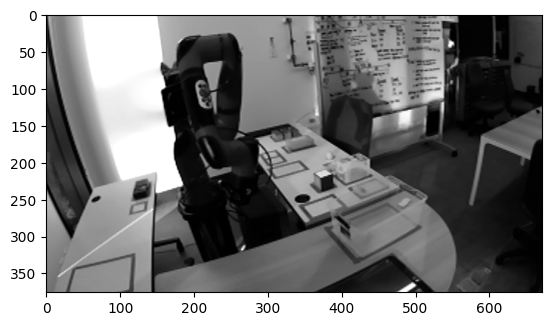

In [56]:
plt.imshow(img_left_gray, cmap="gray")
plt.show()

In [58]:
"""So, going back to how stereo matching algorithms work, the above function does:
1. matching cost computation: our cost function subtracting individual pixel values and squaring
2. cost (support) aggregation: our cost function aggregating these costs in a window
3. disparity computation: simply finding the disparity based on the minimum cost"""

# because it would take forever to do the whole image, we are going to crop both left and right images
top, left = 25, 150
bottom, right = 250, 400
img_left_gray_crop = img_left_histEq[top:bottom,left:right]
img_right_gray_crop = img_right_histEq[top:bottom,left:right]


cost_matrix, best_disparity_img = get_disparity(img_left_gray_crop, img_right_gray_crop)

In [ ]:


# img_left_crop = img_left_histEq[top:bottom,left:right]
# img_right_crop = img_right_histEq[top:bottom,left:right]
# cost_matrix_color, best_disparity_img_color = get_disparity(img_left_crop, img_right_crop, kernel_width=21, kernel_height=21)

In [59]:
# Now we get the depth 
# Set dummy variabels for b and f_x
b = 63.1542 # In centimeters
f_x = (386.94+386.13)/2 # getting the average between the two cameras
best_depth_img = (b*f_x)/best_disparity_img

C:\Users\Joshua\AppData\Local\Temp\ipykernel_36436\327894685.py:5: RuntimeWarning: divide by zero encountered in divide
  best_depth_img = (b*f_x)/best_disparity_img


(225, 250)
[[  1.   1.   1. ...   6.   6.   6.]
 [  1.   1.   1. ...   6.   6.   6.]
 [  7.   5.   0. ...   6.   6.   6.]
 ...
 [  0.   0. 197. ...  12.  12.  12.]
 [206. 197. 197. ...  12.  12.  12.]
 [206. 206. 197. ...  12.  12.  12.]]


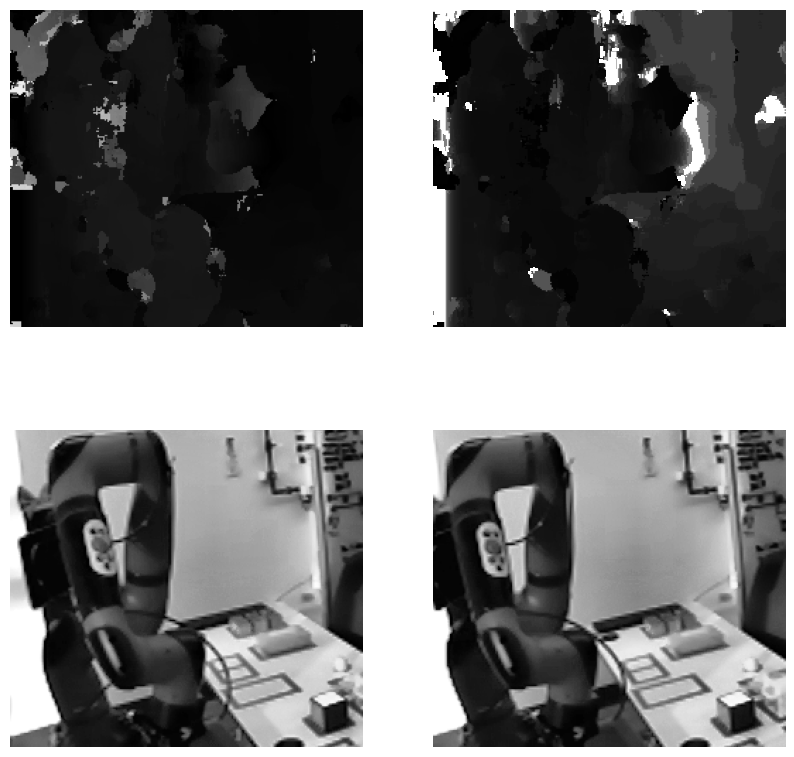

In [60]:
# Now lets show the disparity matrix as an image
print(best_disparity_img.shape)
print(best_disparity_img)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(best_disparity_img, cmap="gray")
axs[0, 0].axis("off")
axs[0, 1].imshow(best_depth_img, cmap="gray")
axs[0, 1].axis("off")
axs[1, 0].imshow(img_left_gray_crop, cmap="gray")
axs[1, 0].axis("off")
axs[1, 1].imshow(img_right_gray_crop, cmap="gray")
axs[1, 1].axis("off")

plt.show()

C:\Users\Joshua\AppData\Local\Temp\ipykernel_36436\776107532.py:1: RuntimeWarning: divide by zero encountered in divide
  best_depth_img_color = (b*f_x)/best_disparity_img_color


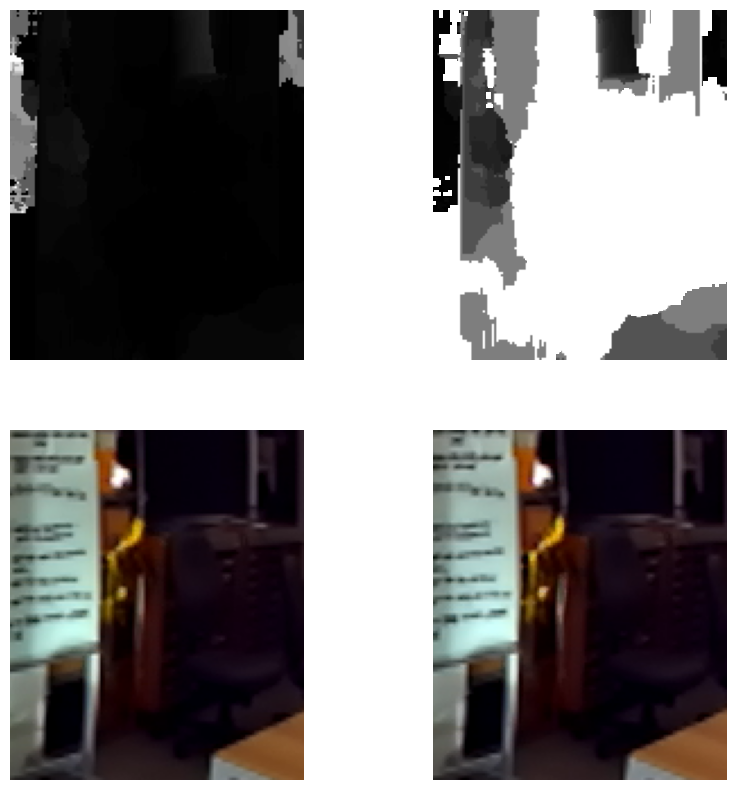

In [ ]:
# best_depth_img_color = (b*f_x)/best_disparity_img_color

# # Best depth from color image
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# axs[0, 0].imshow(best_disparity_img_color, cmap="gray")
# axs[0, 0].axis("off")
# axs[0, 1].imshow(best_depth_img_color, cmap="gray")
# axs[0, 1].axis("off")
# axs[1, 0].imshow(img_left_crop)
# axs[1, 0].axis("off")
# axs[1, 1].imshow(img_right_crop)
# axs[1, 1].axis("off")

# plt.show()

1. Find dense correspondence between pixels in the images
- Non-trivial, will need an algorithm to go across each horizontal line in the image and find corresponding positions with as little noise (mismatches) as possible
2. Then calculate 

Questions:
- What is the disparity space image. In my mind it is the following: for every pixel in the image we have a matrix of all other pixels in the other image with a value that represents the cost. The disparity is then if we used that pixel as the match between the two images.

In [ ]:
# Now that we have these correspondences, we can compute depth

# How to actually calculate disparity

# Algorithm for dense correspondence
# dehttps://learnopencv.com/depth-perception-using-stereo-camera-python-c/ 

# Penn state:
# https://www.cse.psu.edu/~rtc12/CSE486/lecture09.pdf 

# Middlebury taxonomy of stereo algorithms:
# https://vision.middlebury.edu/stereo/taxonomy-IJCV.pdf

# 2011 dense correspondence algorithm with public repo

# More complicated but well done stereo algorithm:
# https://ieeexplore.ieee.org/document/5940405 

"""
Next steps:
- DONE: Finish the very basic stereo matching algorithm
    - Create cost function
    - Go through each row pixel by pixel and find the best pixel based on 
    minimizing the cost function
    - Get the pixel it corresponds to the most, compute its disparity, then store it in the
    disparity image
    - Go through image and apply the function to go from disparity to depth
- Figure out if depth is working
"""

"""
Ask Prof Wloka:
- Is the depth thing working?
- Why is it taking so long? Is there a faster way?
Next steps:
- Debug the depth calculation algorithm manually
    - As in make a picture where you know the depth and make sure the ZED-M camera is giving you back the right depth
- Once you got that working redo the stereo matching algorithm
    - If it still doesn't work it is probably an issue with correspondence, i.e., finding dense features
- Do some optimizations to make it faster
"""




'\nNext steps:\n- Finish the very basic stereo matching algorithm\n    - Create cost function\n    - Go through each row pixel by pixel and find the best pixel based on \n    minimizing the cost function\n    - Get the pixel it corresponds to the most, compute its disparity, then store it in the\n    disparity image\n    - Go through image and apply the function to go from disparity to depth\n'